### WARNGING: OLD VERSION- Now moved to cogtoolslab/lax repo

In [744]:
import os
import sys
import urllib, io
os.getcwd()
sys.path.append("..")
# sys.path.append("../utils")
sys.path.append("../../stimuli")
sys.path.append("../../stimuli/block_utils/")


import numpy as np
import scipy.stats as stats
import pandas as pd

import pymongo as pm
from collections import Counter
from functools import reduce
import json
import re
import ast

from PIL import Image, ImageOps, ImageDraw, ImageFont 

from io import BytesIO
import base64

import  matplotlib
from matplotlib import pylab, mlab, pyplot
%matplotlib inline
from IPython.core.pylabtools import figsize, getfigs
plt = pyplot
import matplotlib as mpl
mpl.rcParams['pdf.fonttype'] = 42

import seaborn as sns
sns.set_context('talk')
sns.set_style('darkgrid')

from IPython.display import clear_output

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", message="numpy.dtype size changed")
warnings.filterwarnings("ignore", message="numpy.ufunc size changed")

import drawing_utils as drawing
import importlib
import scoring

import blockworld_utils as utils

In [703]:
## directory & file hierarchy
proj_dir = os.path.abspath('..')
datavol_dir = os.path.join(proj_dir,'data')
analysis_dir =  os.path.abspath('.')
results_dir = os.path.join(proj_dir,'results')
plot_dir = os.path.join(results_dir,'plots')
csv_dir = os.path.join(results_dir,'csv')
json_dir = os.path.join(results_dir,'json')
exp_dir = os.path.abspath(os.path.join(proj_dir,'behavioral_experiments'))
png_dir = os.path.abspath(os.path.join(datavol_dir,'png'))

## add helpers to python path
if os.path.join(proj_dir,'stimuli') not in sys.path:
    sys.path.append(os.path.join(proj_dir,'stimuli'))
    
if not os.path.exists(results_dir):
    os.makedirs(results_dir)
    
if not os.path.exists(plot_dir):
    os.makedirs(plot_dir)   
    
if not os.path.exists(csv_dir):
    os.makedirs(csv_dir)       

In [731]:
# experiment_name = 'prior_elicitation_lax_tower_4_block_unique_silhouettes_procedural'
experiment_name = 'prior_elicitation_lax_tower_4_block_unique_silhouettes_categorization'

iteration_name = 'pilot_1'

In [732]:
# set vars 
auth = pd.read_csv(os.path.join(analysis_dir,'../auth.txt'), header = None) # this auth.txt file contains the password for the sketchloop user
pswd = auth.values[0][0]
user = 'sketchloop'
host = 'cogtoolslab.org'

# have to fix this to be able to analyze from local
import pymongo as pm
conn = pm.MongoClient('mongodb://sketchloop:' + pswd + '@127.0.0.1')

db = conn['lax']
coll = db[experiment_name]

# ## look up number of trials (including paired-practice)
expected_trials = 26

In [733]:
# really_run = False;

# if really_run:
#     db.drop_collection(experiment_name)

In [734]:
df_all = pd.DataFrame(coll.find({'iterationName': iteration_name}))
# all_data[['gameID','trial_index','label']]

In [735]:
# # Find people who have completed all trials
# query = coll.find({"$and":[
#                         {'trialType':'normal-trial'},
#                         {'eventType':'trialEnd'},
#                         {'iterationName': { '$in': [iteration_name] }},
#                         {'trialNum': numTrials-1}]
#                      })

# complete_data_df = pd.DataFrame(query.sort('absoluteTime'))
# complete_data_ids = list(complete_data_df['gameID'])
# print(str(len(complete_data_ids)) + ' participants found')


# pd.DataFrame(coll.find({'iterationName': iteration_name}))

## Filter out metadata

Info about stimulus set downloaded from mongo.
Contains info about tower type.

In [736]:
df_meta = df_all[(df_all.datatype == 'stim_metadata') &
            (df_all.iterationName == iteration_name)]\
        [["gameID","partitionFamily","splitNumber","stimNumbers", "stimGroups",
          "numGames","experimentType","experimentName", "s3_bucket", "versionInd"]]

In [737]:
df_meta

,gameID,partitionFamily,splitNumber,stimNumbers,stimGroups,numGames,experimentType,experimentName,s3_bucket,versionInd
0,2546-d9762c31-f5f0-42a2-ae55-5cd1c8c8cd99,0.0,0.0,"[000, 011, 025, 029, 034, 041, 049, 060, 065, ...","{'100': 'tall', '113': 'neither', '000': 'neit...",0.0,prior_elicitation,ca_prior_elicitation_4_block_unique_silhouette...,lax-tower-4-block-unique-silhouettes-json,0.0
1,6673-9ae0e16d-f5f5-4f1b-a958-03bbb4d201c9,0.0,1.0,"[007, 009, 019, 023, 053, 061, 062, 072, 076, ...","{'106': 'neither', '115': 'tall', '007': 'neit...",0.0,prior_elicitation,ca_prior_elicitation_4_block_unique_silhouette...,lax-tower-4-block-unique-silhouettes-json,0.0
32,5571-1dc04e90-c59c-4740-949b-b95bedcca1e3,0.0,2.0,"[024, 035, 038, 040, 052, 070, 074, 087, 093, ...","{'110': 'neither', '126': 'tall', '129': 'tall...",0.0,prior_elicitation,ca_prior_elicitation_4_block_unique_silhouette...,lax-tower-4-block-unique-silhouettes-json,0.0
33,1339-85b9aee1-fa55-4087-8e52-fad4b7a4cb0f,0.0,3.0,"[003, 012, 026, 064, 069, 073, 077, 082, 098, ...","{'101': 'tall', '103': 'neither', '108': 'neit...",0.0,prior_elicitation,ca_prior_elicitation_4_block_unique_silhouette...,lax-tower-4-block-unique-silhouettes-json,0.0
35,3672-92b7414c-1a5c-4879-bc1a-8865c53a05a5,0.0,4.0,"[002, 013, 037, 039, 042, 043, 059, 063, 092, ...","{'102': 'tall', '123': 'neither', '124': 'neit...",0.0,prior_elicitation,ca_prior_elicitation_4_block_unique_silhouette...,lax-tower-4-block-unique-silhouettes-json,0.0


## Grab trial data

In [738]:
df_trial = df_all[(df_all.datatype == 'trial_end') &
             (df_all.trial_type == 'stimuli-language-production') &
             (df_all.iterationName == iteration_name)]\
            [['datatype', 'iterationName', 'condition',
       'config_name', 'workerID', 'gameID', 'shuffle', 'trialOrder', 'rt',
       'url', 'trial_type', 'trial_index', 'time_elapsed', 'internal_node_id',
       'view_history', 'label', 'stimId', 'stimURL', 'responses']]

### Add metadata to trial data

In [739]:
# verify stim groups in metadata are correct
dicts = list(df_all[df_all.datatype=='stim_metadata']['stimGroups'])

stim_groups = reduce(lambda dict1, dict2: {**dict1, **dict2}, dicts)
pd.Series(list(stim_groups.values())).value_counts()

# assign stim groups from metadata (althoug)
df_trial['stim_group'] = df_trial['stimId'].apply(lambda stim: stim_groups[stim])
df_trial = df_trial.merge(df_meta, how='left', on='gameID')

## Todo: get complete data sets

In [740]:
df_trial.groupby('gameID')['trial_index'].last()

gameID
1339-85b9aee1-fa55-4087-8e52-fad4b7a4cb0f    14.0
2546-d9762c31-f5f0-42a2-ae55-5cd1c8c8cd99    14.0
3672-92b7414c-1a5c-4879-bc1a-8865c53a05a5    14.0
5571-1dc04e90-c59c-4740-949b-b95bedcca1e3    14.0
6673-9ae0e16d-f5f5-4f1b-a958-03bbb4d201c9    14.0
Name: trial_index, dtype: float64

## Which batches need re-running? (move to stim_partitioning.ipynb)

TODO: Find incomplete datasets that need to be given to another participant and upload to mongo

- get each gameID + their partitionFamily splitNumber stimNumbers, 
- get number of trials
- work out which batches need to be re-run

In [741]:
df_trial

,datatype,iterationName,condition,config_name,workerID,gameID,shuffle,trialOrder,rt,url,...,stim_group,partitionFamily,splitNumber,stimNumbers,stimGroups,numGames,experimentType,experimentName,s3_bucket,versionInd
0,trial_end,pilot_1,all,lax-tower-4-block-unique-silhouettes-categoriz...,61083aaf80d3f6135717fa38,6673-9ae0e16d-f5f5-4f1b-a958-03bbb4d201c9,NaN,NaN,40648.0,NaN,...,tall,0.0,1.0,"[007, 009, 019, 023, 053, 061, 062, 072, 076, ...","{'106': 'neither', '115': 'tall', '007': 'neit...",0.0,prior_elicitation,ca_prior_elicitation_4_block_unique_silhouette...,lax-tower-4-block-unique-silhouettes-json,0.0
1,trial_end,pilot_1,all,lax-tower-4-block-unique-silhouettes-categoriz...,61083aaf80d3f6135717fa38,6673-9ae0e16d-f5f5-4f1b-a958-03bbb4d201c9,NaN,NaN,73182.3,NaN,...,neither,0.0,1.0,"[007, 009, 019, 023, 053, 061, 062, 072, 076, ...","{'106': 'neither', '115': 'tall', '007': 'neit...",0.0,prior_elicitation,ca_prior_elicitation_4_block_unique_silhouette...,lax-tower-4-block-unique-silhouettes-json,0.0
2,trial_end,pilot_1,all,lax-tower-4-block-unique-silhouettes-categoriz...,61083aaf80d3f6135717fa38,6673-9ae0e16d-f5f5-4f1b-a958-03bbb4d201c9,NaN,NaN,15059.1,NaN,...,neither,0.0,1.0,"[007, 009, 019, 023, 053, 061, 062, 072, 076, ...","{'106': 'neither', '115': 'tall', '007': 'neit...",0.0,prior_elicitation,ca_prior_elicitation_4_block_unique_silhouette...,lax-tower-4-block-unique-silhouettes-json,0.0
3,trial_end,pilot_1,all,lax-tower-4-block-unique-silhouettes-categoriz...,61083aaf80d3f6135717fa38,6673-9ae0e16d-f5f5-4f1b-a958-03bbb4d201c9,NaN,NaN,8634.5,NaN,...,wide,0.0,1.0,"[007, 009, 019, 023, 053, 061, 062, 072, 076, ...","{'106': 'neither', '115': 'tall', '007': 'neit...",0.0,prior_elicitation,ca_prior_elicitation_4_block_unique_silhouette...,lax-tower-4-block-unique-silhouettes-json,0.0
4,trial_end,pilot_1,all,lax-tower-4-block-unique-silhouettes-categoriz...,61083aaf80d3f6135717fa38,6673-9ae0e16d-f5f5-4f1b-a958-03bbb4d201c9,NaN,NaN,31539.9,NaN,...,neither,0.0,1.0,"[007, 009, 019, 023, 053, 061, 062, 072, 076, ...","{'106': 'neither', '115': 'tall', '007': 'neit...",0.0,prior_elicitation,ca_prior_elicitation_4_block_unique_silhouette...,lax-tower-4-block-unique-silhouettes-json,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
60,trial_end,pilot_1,all,lax-tower-4-block-unique-silhouettes-categoriz...,61093130bd622cd1d115d81d,1339-85b9aee1-fa55-4087-8e52-fad4b7a4cb0f,NaN,NaN,71344.7,NaN,...,neither,0.0,3.0,"[003, 012, 026, 064, 069, 073, 077, 082, 098, ...","{'101': 'tall', '103': 'neither', '108': 'neit...",0.0,prior_elicitation,ca_prior_elicitation_4_block_unique_silhouette...,lax-tower-4-block-unique-silhouettes-json,0.0
61,trial_end,pilot_1,all,lax-tower-4-block-unique-silhouettes-categoriz...,61093130bd622cd1d115d81d,1339-85b9aee1-fa55-4087-8e52-fad4b7a4cb0f,NaN,NaN,60465.0,NaN,...,neither,0.0,3.0,"[003, 012, 026, 064, 069, 073, 077, 082, 098, ...","{'101': 'tall', '103': 'neither', '108': 'neit...",0.0,prior_elicitation,ca_prior_elicitation_4_block_unique_silhouette...,lax-tower-4-block-unique-silhouettes-json,0.0
62,trial_end,pilot_1,all,lax-tower-4-block-unique-silhouettes-categoriz...,61093130bd622cd1d115d81d,1339-85b9aee1-fa55-4087-8e52-fad4b7a4cb0f,NaN,NaN,37529.4,NaN,...,neither,0.0,3.0,"[003, 012, 026, 064, 069, 073, 077, 082, 098, ...","{'101': 'tall', '103': 'neither', '108': 'neit...",0.0,prior_elicitation,ca_prior_elicitation_4_block_unique_silhouette...,lax-tower-4-block-unique-silhouettes-json,0.0
63,trial_end,pilot_1,all,lax-tower-4-block-unique-silhouettes-categoriz...,61093130bd622cd1d115d81d,1339-85b9aee1-fa55-4087-8e52-fad4b7a4cb0f,NaN,NaN,39244.3,NaN,...,neither,0.0,3.0,"[003, 012, 026, 064, 069, 073, 077, 082, 098, ...","{'101': 'tall', '103': 'neither', '108': 'neit...",0.0,prior_elicitation,ca_prior_elicitation_4_block_unique_silhouette...,lax-tower-4-block-unique-silhouettes-json,0.0


## Data preprocessing

In [742]:
list(df_trial.groupby('stimId').first()['label'])

['h with red and blue\n',
 'Chairs stacked perfectly',
 'a sideways thumbs up, thumb and base of hand blue, two fingers are red',
 'a chair tipped over on its side',
 'a creature (maybe an insect?) lifting its leg up in the air',
 'two ls one upside down',
 'a sideways view of a bed looking right. red headboard, blue mattress, red vertical bar at foot of bed. blue horizontal bar at the bottom of the head of bed',
 'A U',
 'a whirlpool viewed from above',
 'a podium or table of some sort',
 'a table. ',
 'republican ',
 'backwards lowercase "h". red bars as the vertical line, 2 horizontal blue lines as the curve in the h',
 'two red up two blue down',
 'an S',
 'Looks like a staircase on a dock. ',
 'Sitting uncomfortably on a car',
 'Looks like a door on a staircase.',
 'the middle finger',
 'a dragon head with two spikes.',
 "two l's spooning\n",
 'A backwards G',
 'a sexual position',
 'two red up and down two blue sideways',
 'a seat. ',
 'the top of a pitchfork',
 'A Jenga piece be

## Basic plots to test data

  - Make some simple plots
	- Description length over trial num
	- For each tower:
		- display responses
		- variance in desc length
		- mean desc length

In [686]:
# setup block display
block_dims = [(2,1),(1,2)]
block_colors = ['#0A2FB3','#B32F0A']
black = ['#000000','#000000'] # used to display silhouettes
grey = ['#333333','#333333']
world_width = 8
world_height = 8
world_center = int((world_width-1)/2)

In [687]:
towers = pd.read_pickle("../../stimuli/tower_4_block_unique_silhouettes/tower_4_block_unique_silhouettes.pkl")

In [688]:
towers_with_labels = df_trial[['stimId','label','gameID']].groupby('stimId')
# tower_ids = towers_with_labels.first().reset_index()['stimId']

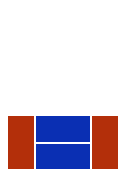

000
['h with red and blue\n']


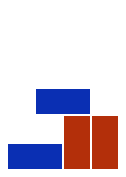

007
['a chair tipped over on its side']


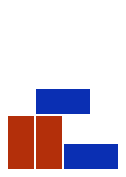

009
['a creature (maybe an insect?) lifting its leg up in the air']


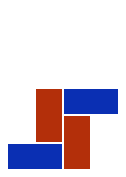

011
['two ls one upside down']


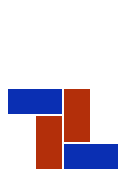

019
['a whirlpool viewed from above']


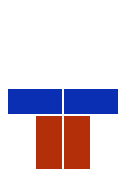

023
['a podium or table of some sort']


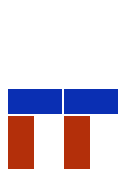

025
['republican ']


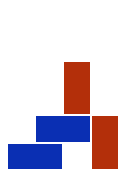

029
['two red up two blue down']


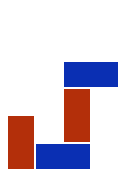

034
['an S']


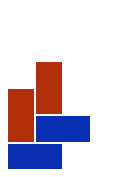

041
["two l's spooning\n"]


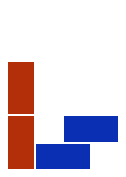

049
['two red up and down two blue sideways']


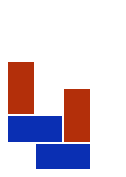

053
['the top of a pitchfork']


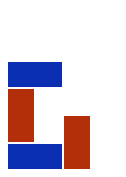

060
['half 0']


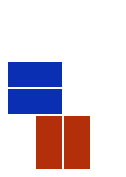

061
['A blue box about to tip over a red box']


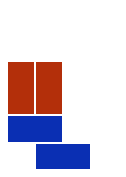

062
["the tip of a dinosaur's tail"]


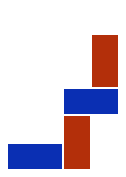

065
['l sideways l backwards']


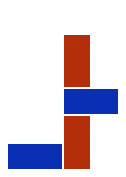

068
['l sideways l normal']


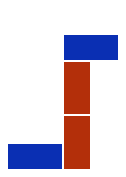

072
['A snake sitting upright']


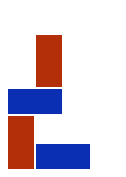

076
['an upside down pirate hook']


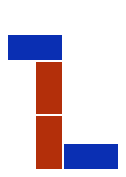

084
['A snake standing upright, facing to the left']


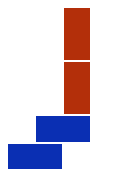

086
['a staircase leading up to a door']


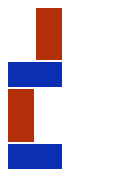

100
['c with a topper']


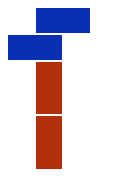

106
['two blue bricks on top of a pole']


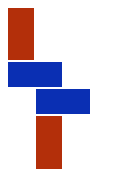

113
['normal l and upside down l']


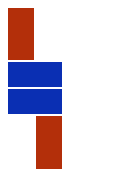

115
["Two L's back to back with each other, but the stems are on opposite sides of each other."]


In [689]:
for towerId, group_df in towers_with_labels:
    utils.draw_tower(utils.worldify(list(towers[towers.tower_number_str == towerId]['stim'])[0],
                                    block_dims = block_dims, 
                                    block_colors = block_colors))
    print(towerId)
    print(list(group_df['label']))

In [649]:
utils.draw_world

<function blockworld_helpers.draw_world(world)>

In [650]:
labels_by_trial_num = df_trial[['stimId','label','gameID','trial_index']].groupby('trial_index')

for trial_num, group_df in labels_by_trial_num:
    print(trial_num)
    print(list(group_df['label']))
    print('\n')
    
    

2.0
['to make this image i would create a blue rectangle to the right laying hamburger way, then i would out another blue hamburger rectangle and lay it on top and moved towards the right, then i would put a red rectangle laying hot dog wise on the first blue retangle, and another to the right of them.\n', 'draw a blue horizontal rectangle on the bottom, then draw a rust orange rectangle (the same size) vertically touching the left side of the blue rectangle, then I would draw another blue horizontal rectangle (the same size) on top of the rust orange rectangle but center it so the edges line up and there is half of the rectangle hanging off to the right, lastly I would draw another rust orange vertical rectangle sitting on top of the previous blue rectangle on the right side with the edges lines up flush.', 'Place two red blocks lengthways...then I would intercept with two blue blocks horizontally...then I would shift the topmost blue block to the left until its rightmost end aligns w

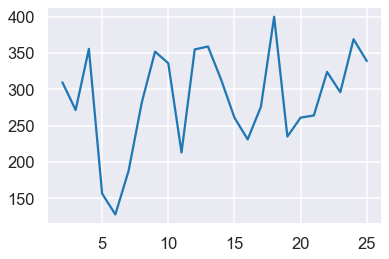

In [651]:
lengths = df_trial[['stimId','label','gameID','trial_index']].groupby('trial_index')['label']\
                    .apply(lambda labels: np.mean([len(label) for label in labels]))
plt.plot(lengths)